# Assignment 1: Multi-Layer Perceptron with MNIST Dataset

In this assignment, you are required to train two MLPs to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database by using PyTorch.

The process will be broken down into the following steps:
>1. Load and visualize the data.
2. Define a neural network. (30 marks)
3. Train the models. (30 marks)
4. Evaluate the performance of our trained models on the test dataset. (20 marks)
5. Analysis your results. (20 marks)

In [27]:
import torch
import numpy as np

---
## Load and Visualize the Data

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [44]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)
# prepare data loaders
def classify_label(dataset, num_classes):
    list_index = [[] for _ in range(num_classes)]
    for idx, datum in enumerate(dataset):
        list_index[datum[1]].append(idx)
    return list_index

def partition_train(list_label2indices: list, num_per_class: int):
    random_state = np.random.RandomState(0)
    list_label2indices_train = []
    for indices in list_label2indices:
        random_state.shuffle(indices)
        list_label2indices_train.extend(indices[:num_per_class])
    return list_label2indices_train

class Indices2Dataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.indices = None

    def load(self, indices: list):
        self.indices = indices

    def __getitem__(self, idx):
        idx = self.indices[idx]
        image, label = self.dataset[idx]
        return image, label

    def __len__(self):
        return len(self.indices)

#  sort train data by label
list_label2indices = classify_label(dataset=train_data, num_classes=10)

# how many samples per class to train
list_train = partition_train(list_label2indices, 500)


# prepare data loaders  
indices2data = Indices2Dataset(train_data)
indices2data.load(list_train)
train_loader = torch.utils.data.DataLoader(indices2data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

D:\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if sys.path[0] == '':


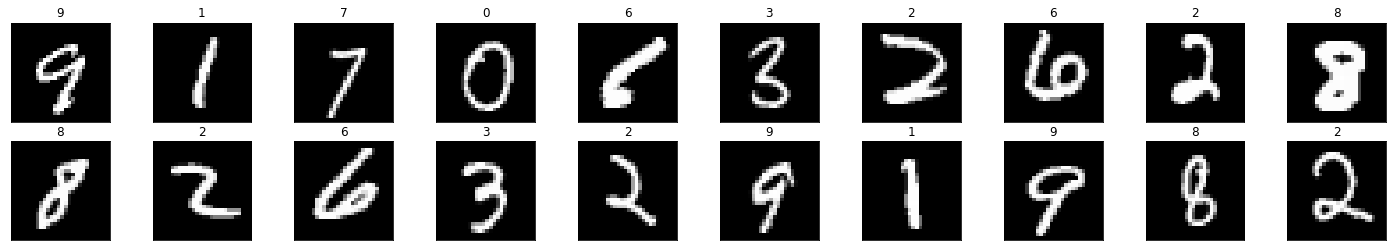

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

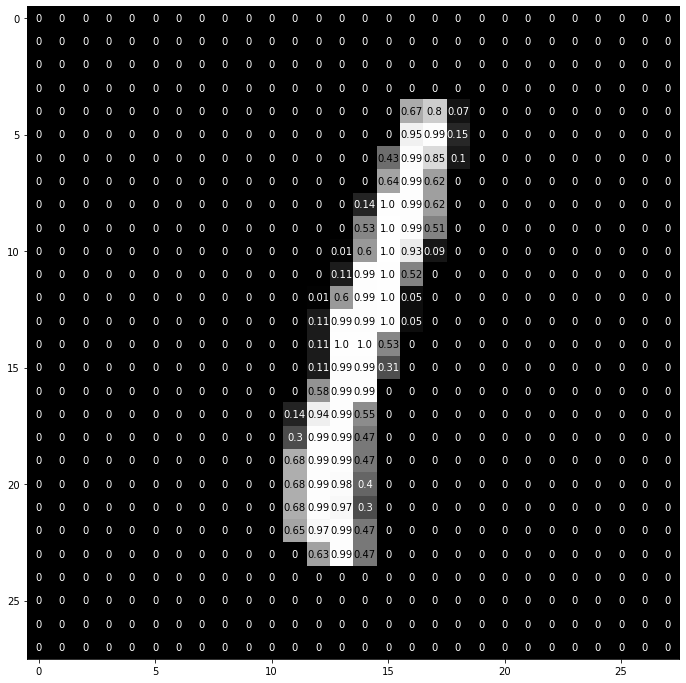

In [18]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network Architecture (30 marks)

* Input: a 784-dim Tensor of pixel values for each image.
* Output: a 10-dim Tensor of number of classes that indicates the class scores for an input image. 

You need to implement three models:
1. a vanilla multi-layer perceptron. (10 marks)
2. a multi-layer perceptron with regularization (dropout or L2 or both). (10 marks)
3. the corresponding loss functions and optimizers. (10 marks)

### Build model_1

In [33]:
## Define the MLP architecture
from torch import nn
class VanillaMLP(nn.Module):
    def __init__(self):
        super(VanillaMLP, self).__init__()
        
        # implement your codes here
        self.model1=nn.Sequential(nn.Linear(784, 256),
                                 nn.ReLU(),
                                 nn.Linear(256, 10))

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)

        # implement your codes here
        x=self.model1(x)
        return x

# initialize the MLP
model_1 = VanillaMLP()

# specify loss function
# implement your codes here
loss_fn1 = nn.CrossEntropyLoss()
# specify your optimizer
# implement your codes here
trainer1 = torch.optim.SGD(model_1.parameters(), lr=0.1)

### Build model_2

In [34]:
## Define the MLP architecture
class RegularizedMLP(nn.Module):
    def __init__(self):
        super(RegularizedMLP, self).__init__()
        
        # implement your codes here
        self.model2=nn.Sequential(nn.Linear(784, 256),
                                  nn.ReLU(),
                                  nn.Dropout(0.2),
                                  nn.Linear(256, 10))
    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)

        # implement your codes here
        x=self.model2(x)
        
        return x

# initialize the MLP
model_2 = RegularizedMLP()

# specify loss function
# implement your codes here
loss_fn2 = nn.CrossEntropyLoss()
# specify your optimizer
# implement your codes here
trainer2 = torch.optim.SGD(model_2.parameters(), lr=0.1)

---
## Train the Network (30 marks)

Train your models in the following two cells.

The following loop trains for 30 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data. 

**The key parts in the training process are left for you to implement.**

### Train model_1

In [36]:
# number of epochs to train the model
n_epochs = 100  # suggest training between 100-150 epochs

model_1.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    total_correct = 0
    
    for data, target in train_loader:
        
        # implement your code here
        outputs=model_1(data)
        loss=loss_fn1(outputs,target)
        trainer1.zero_grad()  
        loss.backward()
        trainer1.step()
        train_loss += loss*data.shape[0]# the total loss of this batch
        index=outputs.argmax(axis=1) 
        cmp=index.type(target.dtype) == target
        correct=float(cmp.type(target.dtype).sum())
        total_correct += correct# the accumulated number of correctly classified samples of this batch
        
    # print training statistics 
    # calculate average loss and accuracy over an epoch
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = 100. * total_correct / len(train_loader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Acc: {:.2f}%%'.format(
        epoch+1, 
        train_loss,
        train_acc
        ))

Epoch: 1 	Training Loss: 0.814388 	Training Acc: 77.56%%
Epoch: 2 	Training Loss: 0.365604 	Training Acc: 89.10%%
Epoch: 3 	Training Loss: 0.283670 	Training Acc: 91.44%%
Epoch: 4 	Training Loss: 0.232543 	Training Acc: 93.06%%
Epoch: 5 	Training Loss: 0.189475 	Training Acc: 94.42%%
Epoch: 6 	Training Loss: 0.157100 	Training Acc: 95.48%%
Epoch: 7 	Training Loss: 0.130782 	Training Acc: 96.40%%
Epoch: 8 	Training Loss: 0.107314 	Training Acc: 97.16%%
Epoch: 9 	Training Loss: 0.088530 	Training Acc: 97.82%%
Epoch: 10 	Training Loss: 0.073555 	Training Acc: 98.16%%
Epoch: 11 	Training Loss: 0.060874 	Training Acc: 98.68%%
Epoch: 12 	Training Loss: 0.048888 	Training Acc: 99.02%%
Epoch: 13 	Training Loss: 0.040475 	Training Acc: 99.40%%
Epoch: 14 	Training Loss: 0.034201 	Training Acc: 99.56%%
Epoch: 15 	Training Loss: 0.029333 	Training Acc: 99.70%%
Epoch: 16 	Training Loss: 0.023786 	Training Acc: 99.82%%
Epoch: 17 	Training Loss: 0.020234 	Training Acc: 99.94%%
Epoch: 18 	Training Los

### Train model_2

In [37]:
# number of epochs to train the model
n_epochs = 100  # suggest training between 100-150 epochs

model_2.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    total_correct = 0
    
    for data, target in train_loader:
        
        # implement your code here
        outputs=model_2(data)
        loss=loss_fn2(outputs,target)
        trainer2.zero_grad()  
        loss.backward()
        trainer2.step()
        train_loss += loss*data.shape[0]# the total loss of this batch
        index=outputs.argmax(axis=1) 
        cmp=index.type(target.dtype) == target
        correct=float(cmp.type(target.dtype).sum())
        total_correct += correct# the accumulated number of correctly classified samples of this batch
        
    # print training statistics 
    # calculate average loss and accuracy over an epoch
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = 100. * total_correct / len(train_loader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Acc: {:.2f}%%'.format(
        epoch+1, 
        train_loss,
        train_acc
        ))

Epoch: 1 	Training Loss: 0.841821 	Training Acc: 76.96%%
Epoch: 2 	Training Loss: 0.384055 	Training Acc: 88.46%%
Epoch: 3 	Training Loss: 0.303606 	Training Acc: 91.12%%
Epoch: 4 	Training Loss: 0.239208 	Training Acc: 92.94%%
Epoch: 5 	Training Loss: 0.205305 	Training Acc: 93.66%%
Epoch: 6 	Training Loss: 0.169879 	Training Acc: 94.96%%
Epoch: 7 	Training Loss: 0.142771 	Training Acc: 95.58%%
Epoch: 8 	Training Loss: 0.120385 	Training Acc: 96.48%%
Epoch: 9 	Training Loss: 0.101385 	Training Acc: 97.34%%
Epoch: 10 	Training Loss: 0.089584 	Training Acc: 97.68%%
Epoch: 11 	Training Loss: 0.073499 	Training Acc: 98.06%%
Epoch: 12 	Training Loss: 0.065271 	Training Acc: 98.50%%
Epoch: 13 	Training Loss: 0.055216 	Training Acc: 98.84%%
Epoch: 14 	Training Loss: 0.047870 	Training Acc: 99.02%%
Epoch: 15 	Training Loss: 0.044223 	Training Acc: 99.12%%
Epoch: 16 	Training Loss: 0.039586 	Training Acc: 99.22%%
Epoch: 17 	Training Loss: 0.032958 	Training Acc: 99.46%%
Epoch: 18 	Training Los

---
## Test the Trained Network (20 marks)

Test the performance of trained models on test data. Except the total test accuracy, you should calculate the accuracy for each class.

### Test model_1

In [41]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model_1.eval() # prep model for *evaluation*

for data, target in test_loader:
    
    # implement your code here
    outputs = model_1(data)
    loss = loss_fn1(outputs,target)
    test_loss = test_loss+loss*data.shape[0]# the total loss of this batch
    index=outputs.argmax(axis=1)
    cmp=index.type(target.dtype) == target
    for i in range(data.shape[0]):
        if(cmp[i]==1):
            label=target[i]
            class_correct[label]=class_correct[label]+1# the list of number of correctly classified samples of each class of this batch. label is the index.
    
    for label in target:
        class_total[label] = class_total[label]+1# the list of total number of samples of each class of this batch. label is the index.
    
# calculate and print avg test loss
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of class %d: %.2f%%' % (i, 100 * class_correct[i] / class_total[i]))
    else:
        print('Test Accuracy of class %d: N/A (no training examples)' % (i))

print('\nTest Accuracy (Overall): %.2f%%' % (100. * np.sum(class_correct) / np.sum(class_total)))


Test Loss: 0.237582

Test Accuracy of class 0: 98.37%
Test Accuracy of class 1: 98.59%
Test Accuracy of class 2: 93.41%
Test Accuracy of class 3: 93.86%
Test Accuracy of class 4: 94.40%
Test Accuracy of class 5: 93.61%
Test Accuracy of class 6: 95.51%
Test Accuracy of class 7: 95.04%
Test Accuracy of class 8: 92.61%
Test Accuracy of class 9: 93.16%

Test Accuracy (Overall): 94.91%


### Test model_2

In [42]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model_2.eval() # prep model for *evaluation*

for data, target in test_loader:
    
    # implement your code here
    outputs = model_2(data)
    loss = loss_fn2(outputs,target)
    test_loss = test_loss+loss*data.shape[0]# the total loss of this batch
    index=outputs.argmax(axis=1)
    cmp=index.type(target.dtype) == target
    for i in range(data.shape[0]):
        if(cmp[i]==1):
            label=target[i]
            class_correct[label]=class_correct[label]+1# the list of number of correctly classified samples of each class of this batch. label is the index.
    
    for label in target:
        class_total[label] = class_total[label]+1# the list of total number of samples of each class of this batch. label is the index.


# calculate and print avg test loss
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of class %d: %.2f%%' % (i, 100 * class_correct[i] / class_total[i]))
    else:
        print('Test Accuracy of class %d: N/A (no training examples)' % (i))

print('\nTest Accuracy (Overall): %.2f%%' % (100. * np.sum(class_correct) / np.sum(class_total)))

Test Loss: 0.194490

Test Accuracy of class 0: 98.16%
Test Accuracy of class 1: 98.59%
Test Accuracy of class 2: 93.99%
Test Accuracy of class 3: 94.75%
Test Accuracy of class 4: 96.44%
Test Accuracy of class 5: 94.73%
Test Accuracy of class 6: 95.20%
Test Accuracy of class 7: 95.91%
Test Accuracy of class 8: 93.74%
Test Accuracy of class 9: 92.47%

Test Accuracy (Overall): 95.44%


---
## Analyze Your Result (20 marks)
Compare the performance of your models with the following analysis. Both English and Chinese answers are acceptable.
1. Does your vanilla MLP overfit to the training data? (5 marks)

Answer: yes

2. If yes, how do you observe it? If no, why? (5 marks)

Answer: For vanilla MLP,the training loss is lower than the test loss and the training accuracy is higher than test accuracy.

3. Is regularized model help prevent overfitting? (5 marks)

Answer: For regularized model,overfitting is alleviated.

4. Generally compare the performance of two models. (5 marks)

Answer: The test accuracy of  regularized model is higher than that of vanilla MLP and The test loss of  regularized model is higher than that of vanilla MLP. So,the regularized model is better.
